## Getting the cost of that extra conversion
The idea of this notebook is to develop a set of functions that allows the user to compute the extra cost of a conversion on any given product and media channel. That is, as a business owner, one may advertise themselves on an online platform from which they obtain customers.

What I assume is that, at any given level, getting an additional customer is going to be more expensive than the last one. Another way of looking at that is that another dollar worth of investment is going to yield a lesser proportion of customers than the previous dollar.

I will be using synthetic data for different products advertised on different platforms.

The main output of this notebook is a toolbox consisting on different calculators that allow the user to obtain some useful insights.

### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import json

from matplotlib.ticker import FormatStrFormatter
import matplotlib as mpl
import matplotlib.dates as mdates

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Import file

In [3]:
file = r'C:\Users\HP\Desktop\SH - Profesional\Data Science and Machine Learning\Proyectos\Movistar\Dataset\All countries\Argentina\Synthetic data.xlsx'
data = pd.read_excel(file, index_col = 'DATE')

In [4]:
data.PRODUCT.unique().tolist()

['Product1', 'Product6', 'Product5', 'Product3', 'Product4', 'Product2']

### Exploratory Data Analysis - Part I
I'll perform a simple EDA on this dataset.

In [ ]:
# General things
data.head()
data.isna().sum()
data.shape
data.index
data.columns
data.describe()

# Get unique types of products and platforms
data.PRODUCT.unique()
data.PLATFORM.unique()

#### Some comments - I
1. This is a dataset comprised of 5244 observations. For each data point there are four columns: Product, Platform, Investment, Conversions. The first column corresponds to the kind of product; the second column corresponds to the platform in which certain product is advertised; the third column corresponds to the investment of certain product in certain platform; finally, the fourth column corresponds to the conversions of any given product on a specific platform. Also, each observation corresponds to the investment and conversions of X product on Y platform for Z date.
2. This dataframe ain't formatted appropriately for regression use. Later, I will transform it into an easier-to-handle dataframe.
3. The sample starts at 01-01-2021 and lasts until 28-02-2022. For each date there is more than one observation, since there are multiple products advertised in multiple platforms.
4. There are 6 types of products and 3 types of platforms.
5. By the synthetic nature of this dataset, there are no NA values in this format, but there will be later when the index becomes unique and all product and platforms get their own columns for investment and conversions. That is, there will be dates in which there is no data for certain product and platform.
6. Overall, average investment (for all products, across all platforms) is around 862 dollars, while average conversions are around 164. Max investment is around 5578, while max conversions gets to 1549. There is a lot of dispersion among investment and conversions, given by the standard deviation.
7. As I will not attempt to establish any realtionship between products/platforms, I will not address any correlation between the different combinations of products and platforms. But, it may be interesting to make an extension of this notebook that creates an useful application based on the possible correlation among these variables.

In [ ]:
# Total investment and conversions
data[['INVESTMENT', 'CONVERSIONS']].sum()
data[['INVESTMENT', 'CONVERSIONS']].sum() / len(data.index.unique())
data['INVESTMENT'].sum() / data['CONVERSIONS'].sum()

# Investment and conversions by product, by platform, and by product and platform
by_product = data.groupby('PRODUCT').sum()
by_platform = data.groupby('PLATFORM').sum()
by_product_platform = data.groupby(['PRODUCT', 'PLATFORM']).sum()

# Cost per conversion by product and by platform
(by_product['INVESTMENT'] / by_product['CONVERSIONS']).sort_values(ascending = False)
(by_platform['INVESTMENT'] / by_platform['CONVERSIONS']).sort_values(ascending = False)

#### Some comments - II
1. There is a total investment of 4.5 millions of dollars and total conversions amount to 864K. On average, daily investment was 10.5K and conversions were around 2K.
2. By dividing total investment by total conversions one gets an overall idea of the cost per conversion (CPC). In this case it is around 5.23, that is, on average, every conversion costs around 5 dollars.
3. The same idea from above applies when grouping by product and platform. When grouping by product the most expensive one is Product6 with a CPC of 15.15, while the lowest is Product3 with a CPC of 1.2. When grouping by platform, the most expensive one is Platform2, followed by Platform3, and then Platform1.

In [6]:
def plot_proportions(proportions, title):
    sns.set(rc = {'figure.figsize':(10,8)})
    plt.style.use('dark_background')
    fig = plt.pie(proportions, autopct = '%.2f%%', textprops = {'fontsize': 18, 'color': 'black'})
    plt.title(title, fontsize = 20)
    plt.legend(labels = proportions.index, prop = {'size': 16}, loc = 'upper right')
    plt.show() 

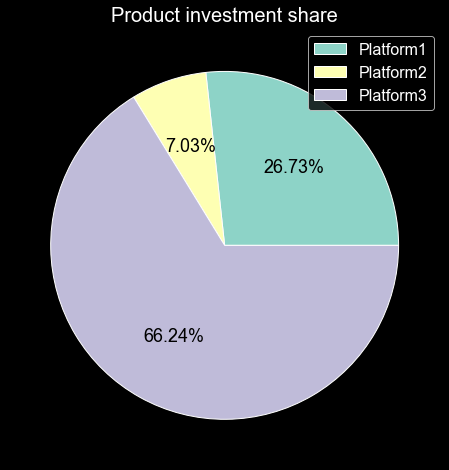

In [8]:
# Investment by product
investment_by_product = data.groupby(['PRODUCT']).sum()['INVESTMENT']
investment_by_platform = data.groupby(['PLATFORM']).sum()['INVESTMENT']
conversions_by_product = data.groupby(['PRODUCT']).sum()['CONVERSIONS']
conversions_by_platform = data.groupby(['PLATFORM']).sum()['CONVERSIONS']

plot_proportions(proportions = investment_by_platform, title = 'Product investment share')

#### Some comments - III
1. When grouped by Product, Product1 takes a little bit more than 56% of total investment, followed by Product4 with 28%. The remaining product take the remaining 14%. The same pattern is observed regarding conversions.
2. When grouped by Platform, Platform3 takes more than two thirds of total investment, followed by Platform1 with almost 27%. Regarding conversions, the same pattern is observed.

### Changing dataset format
The idea of the following lines is to change the format of the dataset to make it more useful for a regression model.

In [9]:
dfs_dict = {}

for i in data.PRODUCT.unique():
    for j in data.PLATFORM.unique():
        temp = data[(data['PRODUCT'] == i) & (data['PLATFORM'] == j)]
        if temp.empty:
            pass
        else:
            temp = temp[['INVESTMENT', 'CONVERSIONS']]
            temp.columns = ['{} - {} - Investment'.format(i, j), '{} - {} - Conversions'.format(i, j)]
            dfs_dict['{0} - {1}'.format(i, j)] = temp

start_date = data.index.unique().sort_values()[0]
end_date = data.index.unique().sort_values()[-1]

dataset = pd.DataFrame(index = pd.date_range(start = start_date, end = end_date, freq = 'd'))

for i in dfs_dict:
    dataset = pd.merge(dataset, dfs_dict[i], left_index = True, right_index = True, how = 'left')
    
dataset = dataset.fillna(0)
dataset.to_excel(r'C:\Users\HP\Desktop\SH - Profesional\Data Science and Machine Learning\Proyectos\My projects\Conversions tool\Conversions dataset.xlsx')

### Exploratory Data Analysis - Part II
Now, the dataset is in an easier to work with format. Every row is an unique date. Every column is one of two things: investment or converion for a certain combination between products and platforms (it is easy to check that the list of possible combinations is not exhaustive).

The following function allows to plot the investment and conversions of some product in some platform within the same figure. Investment comes in the form of bars, while conversions form a line. There are two possible ways to plot this figure: setting *sort_investment* to False (default) returns a time series plot, while setting it to True returns a plot in which Investment is sorted from lowest (left) to highest (right).

While the timely-ordered plot is quite basic and only allows to examine the evolution, the investment-ordered plot is more insightful. It allows to see continuously how conversions react to constant increases (though not equal) in investment. In particular, it can show whether from certain point onwards increases in investment do not impact conversions at all. At this point, one may start to think that the platform is getting saturated, in the sense that no matter how much more money one invests in that particular product in that platform, it ain't gonna get more converions. In this case, it may be advisable to stop investing more money, since that extra conversion (if it is even possible to obtain) is going to be way too expensive.

In [10]:
def plot_investment_conversions(dataset, product, platform, sort_investment = False):
    
    temp = dataset.copy(deep = True)
    temp = temp[[i for i in temp.columns if (product in i) and (platform in i)]]
    
    if sort_investment:
        temp = temp.sort_values(f'{product} - {platform} - Investment').reset_index().drop(['index'], axis = 1)
        
    plt.style.use('dark_background')

    fig, ax1 = plt.subplots(figsize = (16, 8))

    ax1.bar(temp.index, temp[f'{product} - {platform} - Investment'], width = 1, label = 'Investment', color = '#2E507A')
    ax1.set_ylabel('Investment', fontsize = 15)
    ax1.tick_params(axis = 'both', labelsize = 12)
    ax1.set_title(f'{product} - {platform}', fontsize = 20, y = 1)

    ax2 = ax1.twinx()
    ax2.plot(temp.index, temp[f'{product} - {platform} - Conversions'], color = '#78180E', label = 'Conversions')
    ax2.set_ylabel('Conversions', fontsize = 15)
    ax2.tick_params(axis = 'both', labelsize = 12)
    if sort_investment:
        ax2.set_xticks([])

    fig.legend(loc = "upper right", bbox_to_anchor = (1,1), bbox_transform = ax1.transAxes, prop = {'size': 12})

    plt.show()

The previous comment is easy to notice in the next figure (*Product1* in *Platform3*). While at low levels of investment increases in conversions are proportionate, when investment keeps getting higher and higher, specially from 1500 dollars onwards, on average conversions do not increase that much (if they even increase at all). From 3000 dollars onwards it's easily noticeable that on average conversions do not react at all.

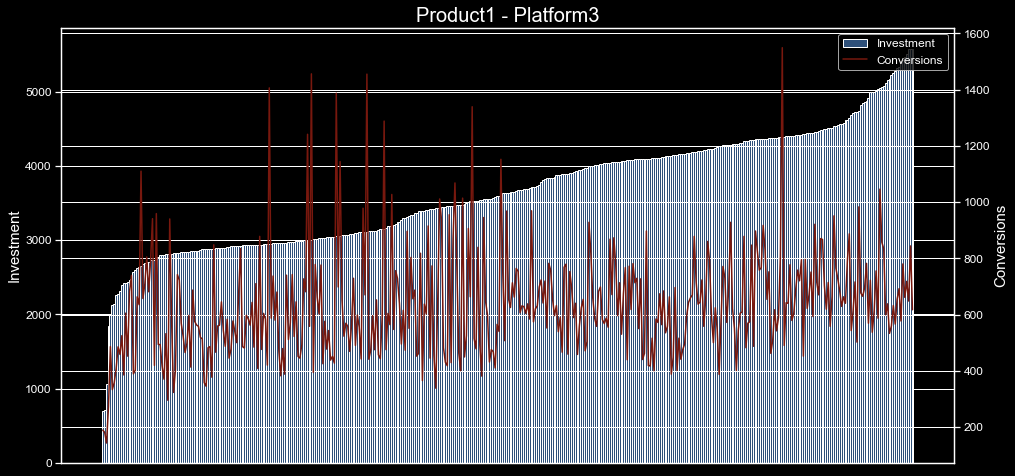

In [11]:
plot_investment_conversions(dataset, 'Product1', 'Platform3', sort_investment = True)

That doesn't seem to be the case in the next figure (*Product1* in *Platform1*), where increases in investment are matched by almost proportionally equal increases in conversions. In any case, as investment keeps going up conversions do go up as well on average.

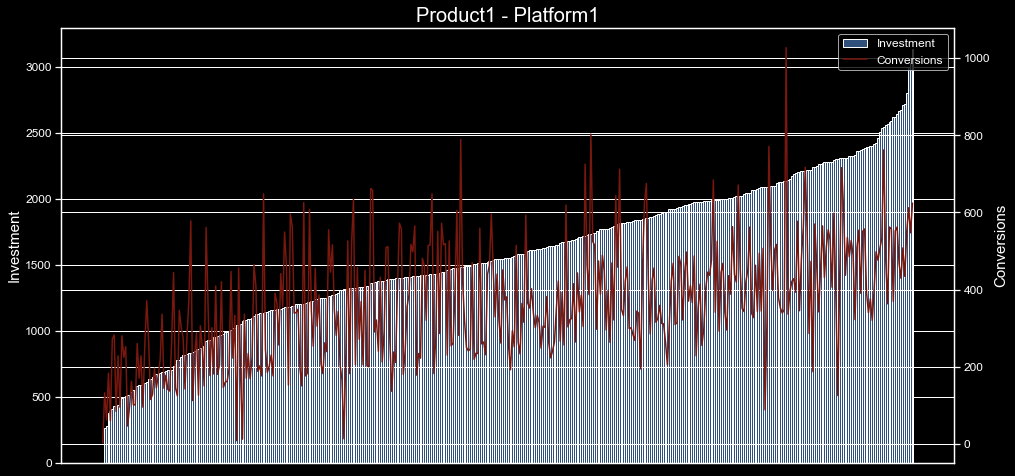

In [12]:
plot_investment_conversions(dataset, 'Product1', 'Platform1', sort_investment = True)

To conclude with this EDA section, I will make some time series plots to see how investment and conversions evolved through time. (I will only show for Product1, both Investment and Conversions.)

<AxesSubplot:>

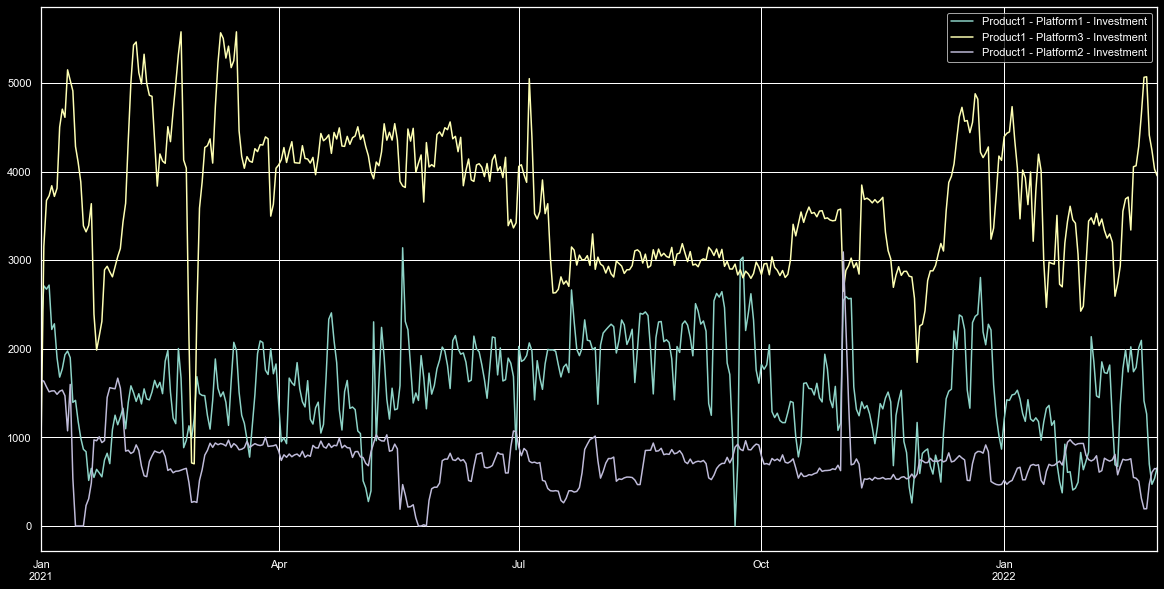

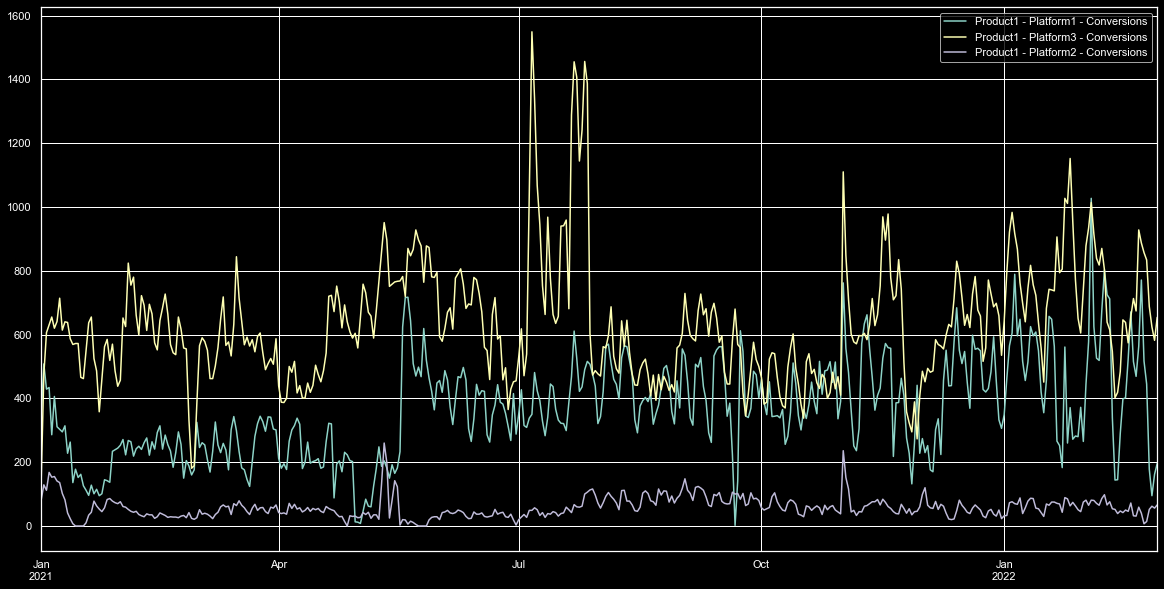

In [13]:
dataset[[i for i in dataset.columns if ('Product1' in i) and ('Investment' in i)]].plot(figsize = (20, 10))
dataset[[i for i in dataset.columns if ('Product1' in i) and ('Conversions' in i)]].plot(figsize = (20, 10))

### Modelling
The idea is to understand what relationship exists between investment and conversions. With domain knowledge at hand, I suspect that there exists a diminishing returns relationship between these two variables, that is, every conversion will be more expensive than the last. Another way of putting it is that every extra dollar invested yields less conversions than the previous dollar.

From a statistical standpoint, what I'll be doing is implementing a simple regression model with a constant. The dependent variable will be the conversions for a specific product in a specific platform; the independent variable will be, as expected, investment. To model the idea of diminishing returns I will be applying the square root to investment. There are other possibilities such as taking the fourth root or logarithms, but I got the best results with square root. One may also try out a sigmoidal transformation, but this approach implies that there is a roof for top conversions, unrelated to the level of investment. With the square root there is no such roof, but it will get very expensive to get that extra conversion at higher levels of investment.

Another reason for restricting myself to just square root is that it is easy to work with, specially later when I create some tools to gain insights using the results from the models. Since the results make overall sense, the suspected relationship is modelled, and it's easy to work with, then I will be sticking myself only to square root, regardless of other possibilities.

One may find interesting to include variables that account for special business events such as holidays, special offers, etc. The reason behind this is that if there is a special event that leads to more conversions, then the model will be picking a relationship that is not entirely correct (even if this special event only lasts a few days or weeks). It'll bias the results, making the model believe that investment is more profitable than it actually is. One should include dummy variables if we know for a fact that certain product in certain platform had an special event. In this case, since it is synthetic data, I have no such information.

It might be also interesting to include adstock of investment. The idea behind this is that if I invest a 100 dollars today it will not only have an impact today, but also tomorrow and the after and so on, but to a lesser degree. But the truth is that I tried this approach and it didn't yield any good results, that is, p-values were always quite bad. Therefore, I decided to not include in this notebook. But is worth the shot. One argument in favor of excluding this variable is the possibility that one is considering online marketing channels which usually have an inmediate impact, since including adstock implies that the impact spreads out during the following days, then it is reasonable that the results of adstocked investment are not statiscally significant.

#### Some useful functions
1. transform_columns: Creates the square root transformation needed to model the diminishing returns concepto.
2. fit_results: Fits a model with a constant and an independent variable, returns those results.
3. get_results: Returns a fitted model from which one may obtain the coefficients (useful for later applications) or, since we are using only two variables (and one is just a constant), it may return a simple scatterplot that shows conversions on the Y-axis and investment on the X-axis, and the corresponding fitted curve.

In [14]:
def transform_column(column, dataframe):
        
    return np.sqrt(dataframe[column])

In [15]:
def fit_results(dataframe, y_column, x_columns, constant = True):
    
    y = dataframe[y_column]
    x = dataframe[x_columns]
    
    if constant:
        x = sm.add_constant(x)
        
    model = sm.OLS(y, x)
    results = model.fit()
    
    return results

In [16]:
def get_results(df, variable, show_results = False):
    
    temp = df[[variable + ' - Investment', variable + ' - Conversions']].copy(deep = True)
    temp = temp.loc[~(temp == 0).any(axis = 1)]
    temp[variable + ' - Investment_sqrt'] = transform_column([variable + ' - Investment'], temp)

    y = [variable + ' - Conversions']
    x = [variable + ' - Investment_sqrt']
    
    results = fit_results(temp, y, x, constant = True)
    
    if show_results:
        return results
    
    max_investment = temp[variable + ' - Investment'].max() * 1.1
    min_investment = temp[variable + ' - Investment'].min()
    invest = np.arange(min_investment, max_investment)
    y = results.params[variable + ' - Investment_sqrt'] * np.sqrt(invest) + results.params['const']        

    plt.figure(figsize = (16, 8))
    plt.style.use('dark_background')
    ax = plt.axes()
    ax.scatter(temp[[variable + ' - Investment']], temp[[variable + ' - Conversions']], color = '#2E507A')
    ax.plot(invest, y, color = '#78180E')
    plt.title(variable, fontsize = 20)

    ax.set_xlabel('Investment', fontsize = 15)
    ax.set_ylabel('Conversions', fontsize = 15)
    ax.tick_params(axis = 'both', labelsize = 12)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    plt.show()

#### Results

As an example, we fit a model for *Product1* in *Platform1*. The results are as follows:

In [17]:
get_results(dataset, 'Product1 - Platform1', show_results = True).summary()

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                    
==============================================================================================
Dep. Variable:     Product1 - Platform1 - Conversions   R-squared:                       0.278
Model:                                            OLS   Adj. R-squared:                  0.277
Method:                                 Least Squares   F-statistic:                     162.3
Date:                                Tue, 26 Jul 2022   Prob (F-statistic):           1.13e-31
Time:                                        18:27:47   Log-Likelihood:                -2661.9
No. Observations:                                 423   AIC:                             5328.
Df Residuals:                                     421   BIC:                             5336.
Df Model:                                           1                                         
Covariance Type:                            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                    -66.1240     34.362     -1.924      0.055    -133.667       1.419
Product1 - Platform1 - Investment_sqrt    11.0140      0.865     12.740      0.000       9.315      12.713
==============================================================================
Omnibus:                       43.851   Durbin-Watson:                   0.376
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.843
Skew:                           0.767   Prob(JB):                     2.75e-13
Kurtosis:                       3.963   Cond. No.                         214.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It's easy to notice the positive relationship between investment and conversions given by the positive coefficient, which, by the way, is statistically significant. The R2 is low, but I don't care since the next figure will show we have a good model that understands the diminishing returns relationship between these two variables.

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


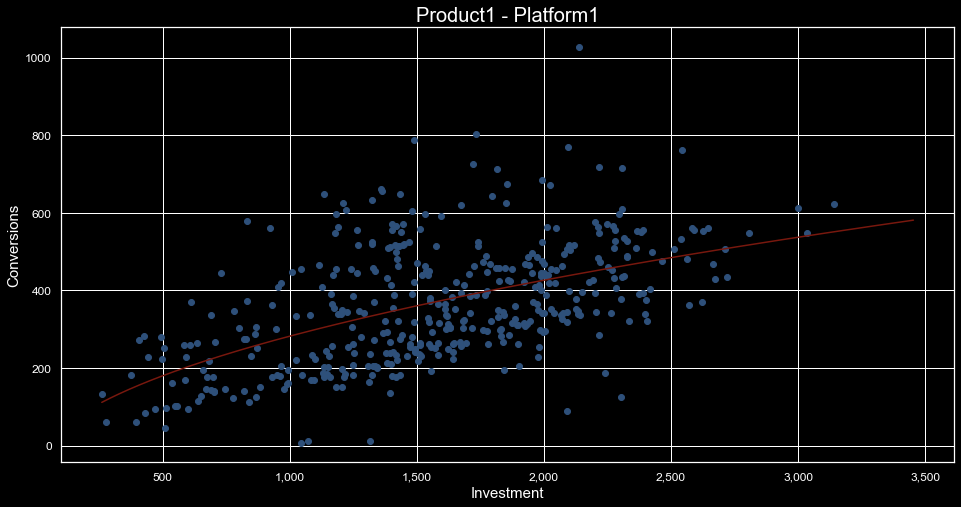

In [18]:
get_results(dataset, 'Product1 - Platform1', show_results = False)

In the previous figure it is easy to see that the higher the investment level, the harder it will be to get X amount of extra conversions given a specific increase in investment. That is, a 100 dollars increase in investment will yield more conversions if we are investing around 1000 dollars compared to what we would get if we were investing, say, 2000 dollars.

For later purposes, it will be useful to obtain the coefficients for both the constant and the investment for all products in all possible platforms.

In [19]:
# Get list of all products and platforms combinations
products_platforms = [i.replace(' - Investment', '') for i in dataset.columns if 'Investment' in i]

# Get model coefficients into a dictionary
params_dict = {}

for i in products_platforms:
    params_dict[i] = get_results(dataset, i, show_results = True).params.tolist()

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [20]:
json.dump(params_dict, open(r'C:\Users\HP\Desktop\SH - Profesional\Data Science and Machine Learning\Proyectos\My projects\Conversions tool\params_dict.json', 'w'))

### Tools
Now it's time to create some tools that will allow to use the models' results to gain some useful insights. 

Questions with business value:
1. Given that one may desire to obtain X amount of conversions, how much will those conversions cost?
2. Given that I'm already obtaining X amoung of conversions, how much will Y extra conversions cost?
3. Given that conversions get more expensive the higher the level of investment, until what point is it profitable to keep getting more converions?
4. Given that I may want X conversions, what is the investment range that guarantees me, almost for certain, to obtain them?

The idea is to create tools that address these questions.

#### 1. Given that one may desire to obtain X amount of conversions, how much will those conversions cost?
Usually, one has a goal of conversions that is supposed to achieve certain month for a given product in certain platform. Why that is is of no concern to me right now, but as that usually is the case, then I'll develop a simple tool that gives a sense of how much money one would need to get those converions. This will be based on the models' results. 

Remember that we are using a simple specification, that is, **conversions = const + beta * sqrt(investment)**. This means we can easily invert this function to **investment = ((conversions - const)/beta)^2**. This gives a simple way to compute, for X amount of desired conversions, how much those conversions are going to cost.

The following function allows to set, for a specific product and platform, a converions goal (daily or monthly) to get the monthly and daily cost, and the average cost per conversion (CPC), which is simply daily cost divided by daily conversions goal.

In [21]:
def get_conversions_cost(product, platform, params_dict, goal_conversions, monthly_goal = True):
    
    params = params_dict[f'{product} - {platform}']
    const = params[0]
    coeff = params[1]
    
    # If monthly_goal is set to True, divide goal_conversions by 30 to get daily goal, since the model is for daily data. Then, multiply cost by 30 to get monthly cost
    if monthly_goal:
        goal_conversions = goal_conversions / 30
        
    daily_cost = ((goal_conversions - const) / coeff) ** 2
    monthly_cost = daily_cost * 30
    cpc = daily_cost / goal_conversions
    
    return {'Monthly cost': monthly_cost, 'Daily cost': daily_cost, 'Cost per conversion': cpc}

For example, for *Product1* in *Platform1*, a monthly conversions goal of 30000, that is, 1000 daily conversions, would have a monthly cost of 280k dollars. 

In [22]:
get_conversions_cost(product = 'Product1', platform = 'Platform1', params_dict = params_dict, goal_conversions = 30000, monthly_goal = True)['Monthly cost']

281091.3209780931

For the same product and platform, a daily conversions goal of 500, that is, 15000 monthly converions, would have a monthly cost of 79260 dollars.

In [23]:
get_conversions_cost(product = 'Product1', platform = 'Platform1', params_dict = params_dict, goal_conversions = 500, monthly_goal = False)

{'Monthly cost': 79260.19663359897,
 'Daily cost': 2642.006554453299,
 'Cost per conversion': 5.284013108906598}

Two important remarks:
1. The way I'm proposing to answer this business questions has one very importante caveat, which is that I'm using there is no time dependence. That is, the money I invest today will have no impact whatsoever tomorrow. In this case, this makes sense since models with adstock do not yield good results, but this is something worth considering if there is evidence that suggests that what we today has an impact tomorrow in terms of possible conversions. If that were the case, a simple function as the one before becomes useless as it doesn't take into account that phenomena.
2. The average CPC is only useful to get an overall grasp of how much each conversion consts. Nonetheless, it should be taken into account the diminishing returns nature of the relationship between investment and conversions. This means that, when taking an average CPC, that number is biased by the first conversions which are quite cheap, which is definitely not the case for conversions obtained at higher levels of investment. Another way of putting it is that, this number doesn't reflect the actual CPC of the last conversions. For example, if we have a daily goal of 5000 conversions, and the CPC is at 1000, what's happening is that the converion number 5000 is way above 1000. Therefore, we need another tool that addresses this issue, there we go next.

#### 2. Given that I'm already obtaining X amoung of conversions, how much will Y extra conversions cost?
As discussed before, we need a better measure of how much each conversion costs at any level of investment. The following tool/function aims to address this business question. The idea is to set an initial level of conversions, taken as a benchmark, and to set an increase of conversions from that level. The output is how much each of those extra conversions is goint to cost.

In [24]:
def get_actual_cpc(product, platform, params_dict, base_conversions, extra_conversions, monthly_goal = True):
    
    params = params_dict[f'{product} - {platform}']
    const = params[0]
    coeff = params[1]
    
    new_conversions = base_conversions + extra_conversions
    
    if monthly_goal:
        base_conversions = base_conversions / 30
        new_conversions = new_conversions / 30
        
    # Get delta of conversions
    conversions_change = new_conversions - base_conversions
    
    # Get delta of cost
    cost_base = ((base_conversions - const) / coeff) ** 2
    cost_new = ((new_conversions - const) / coeff) ** 2
    cost_change = cost_new - cost_base
    
    # Get CPC
    cpc = cost_change / conversions_change
    
    return {'Daily base conversions': base_conversions, 'Daily new conversions': new_conversions, 'Actual CPC': cpc}

In [25]:
get_actual_cpc('Product1', 'Platform1', params_dict, 1000, 1, monthly_goal = False)

{'Daily base conversions': 1000,
 'Daily new conversions': 1001,
 'Actual CPC': 17.585393052861036}

In [26]:
get_conversions_cost(product = 'Product1', platform = 'Platform1', params_dict = params_dict, goal_conversions = 30000, monthly_goal = True)

{'Monthly cost': 281091.3209780931,
 'Daily cost': 9369.71069926977,
 'Cost per conversion': 9.36971069926977}

Let's take a look to the example above. For the same level of monthly conversions, average CPC was around 9.36. As said earlier, this value is downwardly biased since it takes advantage of the fact that the first conversions are quite cheap to get. But, when we get the actual CPC around that amount conversions (30k a month, 1k a day), we see that the CPC is actually 17.58 dollars, which almost doubles the average CPC. The lesson here is that, when we assume a diminishing returns relationship, we should remember that a number such as the CPC may be biased.

Now that we have this tool, it may be of use to know how the CPC increases at different baselines of goal conversions. We might be interested not only in knowing the actual CPC for going from 1000 to 1001 conversions, but also from 1001 to 1002, and 1002 to 1003, and so. We may want to know this to compare the cost of each extra conversion to the value we assign that conversion. Next, I'll address exactly that.

#### 3. Given that conversions get more expensive the higher the level of investment, until what point is it profitable to keep getting more converions?
The idea of the following tool is to get a good grasp of actual CPC at any level of conversions. This will be useful when deciding if that extra conversion is worth the cost or not, since one may compare the increasing cost of one extra conversion to the value assigned to that conversion.

In [27]:
def get_actual_cpc_line(product, platform, params_dict, base_conversions, steps = 100, jump = 1, monthly_goal = True, df = False):
    
    params = params_dict[f'{product} - {platform}']
    const = params[0]
    coeff = params[1]
    
    if monthly_goal:
        base_conversions = base_conversions / 30
        
    new_conversions = base_conversions + jump
    
    cpc_dict = {}
    
    for i in range(steps):
        # Get delta of conversions
        conversions_change = new_conversions - base_conversions

        # Get delta of cost
        cost_base = ((base_conversions - const) / coeff) ** 2
        cost_new = ((new_conversions - const) / coeff) ** 2
        cost_change = cost_new - cost_base

        # Get CPC
        cpc = cost_change / conversions_change
        
        cpc_dict[i] = {'Daily base conversions': base_conversions, 'Daily new conversions': new_conversions, 'Actual CPC': cpc}
        
        base_conversions += jump
        new_conversions += jump
        
    if df:
        return pd.DataFrame.from_dict(cpc_dict).T
        
    return cpc_dict

In [28]:
cpc = get_actual_cpc_line('Product1', 'Platform1', params_dict, 30000, steps = 1000, jump = 10, monthly_goal = True, df = True)

Using the previous function one can get the actual CPC at 1000 daily conversions up to 11000. How do we read the results (the dataframe)? Let's take the first row, going from 1000 daily conversions to 1010 daily conversions, each of those extra conversions cost around 17.66 dollars. If we take the last row, going from 10990 daily conversions to 11000 costs around 182.36 dollars. This is useful information because we can compare it to value we assign to each conversion.

In [29]:
cpc

,Daily base conversions,Daily new conversions,Actual CPC
0,1000.000,1010.000,17.660
1,1010.000,1020.000,17.824
2,1020.000,1030.000,17.989
3,1030.000,1040.000,18.154
4,1040.000,1050.000,18.319
...,...,...,...
995,10950.000,10960.000,181.705
996,10960.000,10970.000,181.870
997,10970.000,10980.000,182.035
998,10980.000,10990.000,182.199


In [30]:
def cpc_vs_threshold(df, threshold_value, find_closest = False):
    
    temp = df.copy(deep = True)
    temp['Threshold'] = threshold_value
    
    if threshold_value < temp['Actual CPC'].min():
        print(f"WARNING: Chosen threshold value {threshold_value} is lower than CPC minimum {round(temp['Actual CPC'].min(), 2)}.")
    elif threshold_value > temp['Actual CPC'].max():
        print(f"WARNING: Chosen threshold value {threshold_value} is higher than CPC maximum {round(temp['Actual CPC'].max(), 2)}.")
       
    if find_closest:
        closest_index = temp['Actual CPC'].sub(threshold_value).abs().idxmin()
        closest_value = {
            'Base conversions': temp.iloc[closest_index]['Daily base conversions'],
            'New conversions': temp.iloc[closest_index]['Daily new conversions'],
            'Actual CPC': temp.iloc[closest_index]['Actual CPC']
        }
        
        print(f"Going from {closest_value['Base conversions']} to {closest_value['New conversions']} is the closest, in terms of CPC, to the specified profitable threshold {threshold_value}.")
        
        return temp, closest_value
    
    return temp

With the previous function we can define a threshold value below which one may say it is worth to try to increase conversions since they are cheaper than what we think they are worth. Above that value, we might want to consider lowering investment since those conversions are more expensive than the defined value. It's easier to plot 'Actual CPC' with the defined 'Threshold' value. For our example, let's define 120 as that value.

<AxesSubplot:>

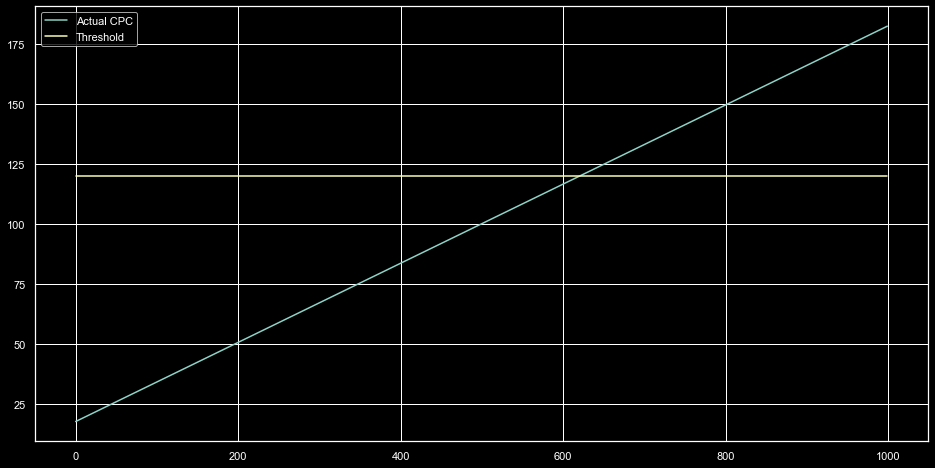

In [34]:
cpc_vs_threshold(cpc, 120, False)[['Actual CPC', 'Threshold']].plot(figsize = (16, 8))

While visually helpful, it is of more value to be able to quickly learn at which point, that is, at what level of conversions, some X amount of extra conversions become more expensive than 120. Therefore, setting the function argument 'find_closest' to True, one may find out that point.

In [32]:
cpc_vs_threshold(cpc, 120, find_closest = True)[1]

Going from 7210.0 to 7220.0 is the closest, in terms of CPC, to the specified profitable threshold 120.


{'Base conversions': 7210.0,
 'New conversions': 7220.0,
 'Actual CPC': 120.04363780768472}

Going through the previous results, the CPC matches the defined threshold when going from 7210 conversions to 7220, so one may want to stop at 7210, because trying to get more conversions than that won't be profitable.

#### 4. Given that I may want X conversions, what is the investment range that guarantees me, almost for certain, to obtain them?

Finally, one may be interested in knowing within what range of investment one may get a desired goal of conversions. This tool aims to address this question by using the models coefficients' confidence intervals at 95% confidence.

In [35]:
def get_investment_range(dataset, product, platform, goal_conversions, monthly_goal = True):
    
    # Get confidence interval for both coefficients
    conf_int = get_results(dataset, f'{product} - {platform}', show_results = True).conf_int(alpha = 0.05)
    
    params = {}
    params['Optimistic'] = conf_int[1].to_list()
    params['Pessimistic'] = conf_int[0].to_list()
    
    # Get investment levels
    investment_range = {}
    
    if monthly_goal:
            goal_conversions = goal_conversions / 30
    
    for i in ['Optimistic', 'Pessimistic']:
        const = params[i][0]
        coeff = params[i][1]
        
        daily_cost = ((goal_conversions - const) / coeff) ** 2
        monthly_cost = daily_cost * 30
        
        investment_range[i] = {'Daily cost': daily_cost, 'Monthly cost': monthly_cost}
        
    return investment_range

Let's say we are interested in knowing how much money would it take to get 1000 daily conversions, but in this case we are planning for best and for worst. Using the coefficients' confidence interval, we get that it would take somewhere between 6200 to 14800 dollars a day to achieve the defined goal.

In [36]:
get_investment_range(dataset, 'Product1', 'Platform1', 30000, monthly_goal = True)

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


{'Optimistic': {'Daily cost': 6169.4841368887055,
  'Monthly cost': 185084.52410666118},
 'Pessimistic': {'Daily cost': 14812.789341262256,
  'Monthly cost': 444383.6802378677}}

### Conclusions

I've performed some EDA on a synthetic dataset and created four tools that address interesting and important questions from a business point of view. There are of course many things that could be added to this analysis, besides many other questions that could be posed. Some of these extensions are:
1. Allowing for the possibility that whatever amount of money we invest today will also have an impact tommorow.
2. Adding many more features to the models, such as holidays, events, promotions, etc.
3. Trying other model specifications that also capture the diminishing returns relationship.
4. Allowing for the possibility that investment in one product has impact on others products (or even platforms).
5. Creating a calculator that allows to optimize between products and platforms.